In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/custom_data/'
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
ori_export = pd.read_csv(path+'exports.csv')
ori_umcsent = pd.read_csv(path+'UMCSENT.csv', skiprows= 10 ,dtype = {'observation_date':str,'UMCSENT':float})
ori_epu = pd.read_csv(path+'EPU.csv')

In [ ]:
for i in ori_export.columns:
  if i != '기간':
    ori_export[i] = pd.to_numeric(ori_export[i].str.replace(pat=r'[^A-Za-z0-9]', repl= '', regex=True),downcast='float')

In [ ]:
f1 = ori_epu['Three_Component_Index'][180:430]
f1.index = np.arange(0,250)
trn_y = ori_export['수출금액'][1:251]
trn_y.index = np.arange(0,250)
DATA = pd.concat([ori_umcsent['UMCSENT'][:250],f1,trn_y],axis=1,ignore_index=True)
DATA.index = ori_export['기간'][1:251]

In [ ]:
def scaling(x):
  min_max_scaler = MinMaxScaler()
  df = x.copy()
  fitted = min_max_scaler.fit(x)
  output = min_max_scaler.transform(x)
  output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
  return output

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X = scaling(DATA)
X.describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.534998,0.215624,0.526546
std,0.215383,0.152158,0.294877
min,0.000000,0.000000,0.000000
25%,0.369489,0.111933,0.273633
50%,0.582892,0.179071,0.603650
75%,0.694885,0.284004,0.792516
max,1.000000,1.000000,1.000000


#9pm

In [ ]:
X.head()

,0,1,2
2000.01,1.000000,0.109116,0.025841
2000.02,0.987654,0.069559,0.037490
2000.03,0.913580,0.069378,0.077262
2000.04,0.950617,0.064301,0.056677
2000.05,0.977072,0.139071,0.081958


#Multi

[참고](https://ahnjg.tistory.com/33)

In [ ]:
X.describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.534998,0.215624,0.526546
std,0.215383,0.152158,0.294877
min,0.000000,0.000000,0.000000
25%,0.369489,0.111933,0.273633
50%,0.582892,0.179071,0.603650
75%,0.694885,0.284004,0.792516
max,1.000000,1.000000,1.000000


In [ ]:
def create_time_steps(length):
  return list(range(-length,0))

In [ ]:
def multivariate_data(dataset,target,start_index,end_index,history_size,target_size,
                      step,single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)-target_size
  
  for i in range(start_index,end_index):
    indices = range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
      
  return np.array(data),np.array(labels)

In [ ]:
def plot_train_history(history,title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs,loss,'b',label='Training loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
dataset = X.values

In [ ]:
dataset.shape

(250, 3)

In [ ]:
future_target = 5
past_history = 5
step = 1

x_train,y_train = multivariate_data(dataset,dataset[:,2],0,125,
                                  past_history,
                                  future_target,step)
x_val,y_val = multivariate_data(dataset,dataset[:,2],125,150,
                                  past_history,
                                  future_target,step)

In [ ]:
x_test.shape

(100, 5, 3)

In [ ]:
print('single window of past history : {}'.format(x_train[0].shape))
print('target to predict : {}'.format(y_train[0].shape))

single window of past history : (5, 3)
target to predict : (5,)


In [ ]:
buffer_size = 95
batch_size = 16
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data_multi = val_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

In [ ]:
def multi_step_plot(history,true_future,prediction):
  plt.figure(figsize=(12,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in,np.array(history[:,2]), label = 'history')
  plt.plot(np.arange(num_out)/step,np.array(true_future),'bo',label='True future')

  if prediction.any():
    plt.plot(np.arange(num_out)/step,np.array(prediction),'ro',label='predicted future')
  plt.legend(loc='upper left')
  plt.show()

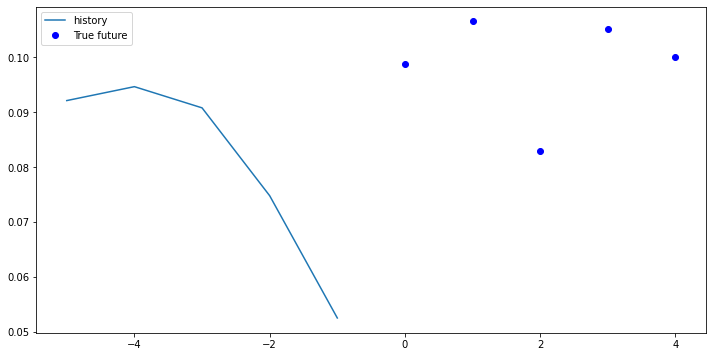

In [ ]:
for x,y in train_data_multi.take(1):
  multi_step_plot(x[0],y[0],np.array([0]))

In [ ]:
import tensorflow as tf

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))

multi_step_model.compile(optimizer='adam',loss='mse')
multi_step_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 5, 32)             4608      
_________________________________________________________________
lstm_27 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 85        
Total params: 7,829
Trainable params: 7,829
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train.shape[-2:]

(5, 3)

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi,epochs=10,
                                          steps_per_epoch=10,
                                          validation_steps=50,
                                          validation_data=val_data_multi,
                                          verbose=0)

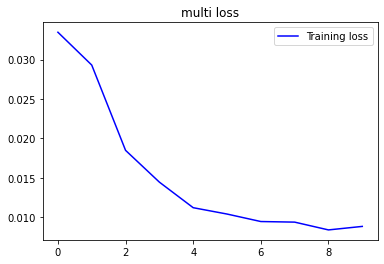

In [ ]:
plot_train_history(multi_step_history,'multi loss')

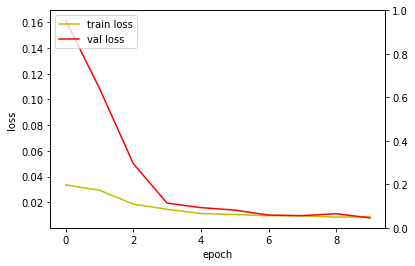

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(multi_step_history.history['loss'], 'y', label='train loss')
loss_ax.plot(multi_step_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

#acc_ax.plot(hist.history['mae'], 'b', label='train mae')
#acc_ax.plot(hist.history['val_mae'], 'g', label='val mae')
#acc_ax.set_ylabel('mae')
#acc_ax.legend(loc='upper left')

plt.show()

(16, 5, 3)


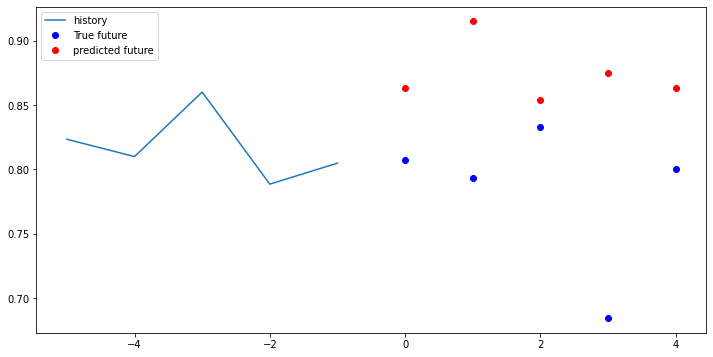

In [ ]:
for x,y in val_data_multi.take(1):
  print(x.shape)
  multi_step_plot(x[0],y[0],multi_step_model.predict(x)[0])

In [ ]:
import numpy as np

multi_step_model.predict(x_test[0].reshape(1,5,3))

array([[0.8612239 , 0.90870506, 0.8610066 , 0.87993413, 0.85399103]],
      dtype=float32)

In [ ]:
x_test[0].reshape(1,5,3).shape

(1, 5, 3)

In [ ]:
x_test,y_test = multivariate_data(dataset,dataset[:,2],145,250,
                                  past_history,
                                  future_target,step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
x_test.shape

(100, 5, 3)

In [ ]:
y_pred = []
for i in range(20):
  data = x_test[5*i].reshape(1,5,3)
  y_pred.append(multi_step_model.predict(data))

In [ ]:
y_pred = np.array(y_pred)
y_pred.shape

(20, 1, 5)

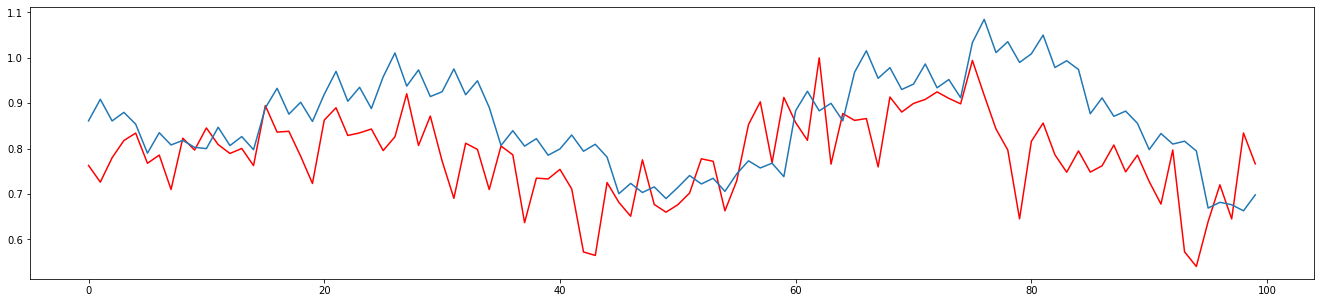

In [ ]:
y_ = y_pred.flatten()
R_y = X[2].values[-100:]
days = np.arange(100)
plt.figure(figsize=(23,5))
plt.plot(days,R_y,'r',days,y_)

In [ ]:
np.savetxt(path+'LSTM.txt', y_, fmt='%.6f', delimiter=',')

# 파라미터 TRAIN 125,epochs=10, steps_per_epoch=10,validation_steps=50